In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import biosppy
from biosppy import storage
from biosppy.signals import ecg
import pyhrv
import pyhrv.tools as tools
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
import os
import scipy.stats
import pywt
import scipy
import scipy.stats as stats

# Exploratory data analysis

In [2]:
fig_local = '../figures/'
directory = '../results'

## Participant demographic analysis 

In [3]:
part_pds =[]
count = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    
    if not os.path.isfile(f): 
        count += 1
        
        part_pd  = pd.read_csv(f + '/participantDetails.csv')
        part_pds.append(part_pd)

part_res = pd.concat(part_pds,axis=0, ignore_index=True)

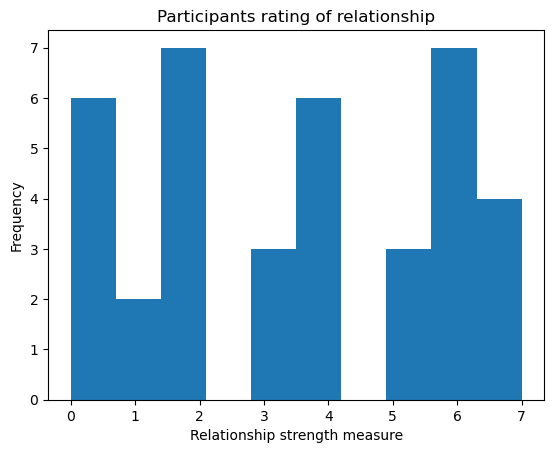

In [4]:
part_res.relationshipStrength.plot(kind='hist')
title = "Participants rating of relationship"
plt.title(title)
plt.xlabel("Relationship strength measure")
plt.savefig(fig_local + title + '.png')
plt.show()

In [5]:
part_exer = part_res.recentExercise.value_counts(normalize=True).loc[True] * 100 
print(f"The amount of participants who exercised prior to the study is {part_exer:.2f}%")

The amount of participants who exercised prior to the study is 7.89%


## Participant emotions analysis

In [6]:
emo_pds =[]
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    
    if not os.path.isfile(f): 
        count += 1
        
        emo_pd  = pd.read_csv(f + '/participantEmotion_recordings.csv')
        emo_pds.append(emo_pd)

emo_res = pd.concat(emo_pds,axis=0, ignore_index=True)
# add unique identifier
uniqueId = emo_res.trialId + emo_res.participant

emo_res.insert (0, "uniqueId", uniqueId)

Assessing whether participants were reported more aroused sauna that at room temperature for match conditions

In [7]:
conditions = ['baseline', 'Look ahead', 'Direct gaze']

diffs = []

for part in emo_res.uniqueId.unique():
    p = emo_res[(emo_res.uniqueId == part) & (emo_res.prevCon.isin(conditions))]
    for con in conditions: 
        diff = p[(p.prevCon == con) & (p.prevEnv == 'Hot')].arousal.values - p[(p.prevCon == con) & (p.prevEnv == 'Room')].arousal.values
        diffs.append(diff[0])

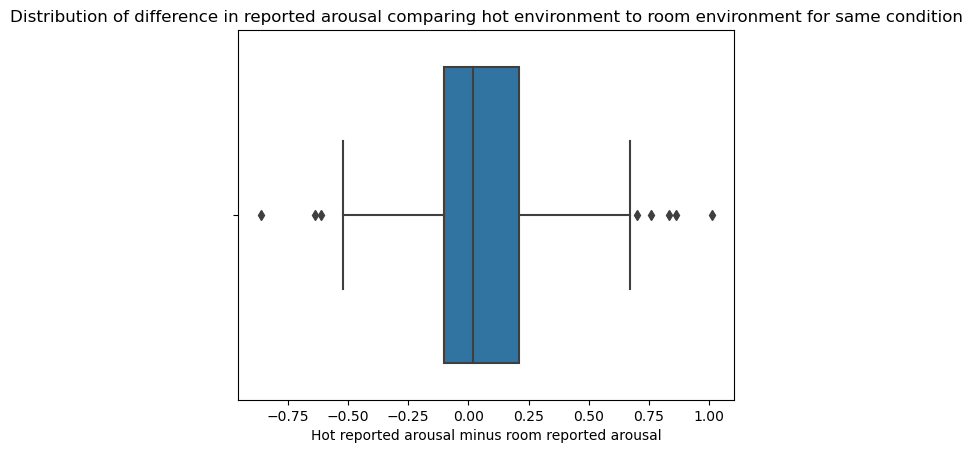

In [8]:
ax = sns.boxplot(diffs)
title = "Distribution of difference in reported arousal comparing hot environment to room environment for same condition" 
plt.title(title)
plt.xlabel("Hot reported arousal minus room reported arousal")
plt.savefig(fig_local + title + '.png')
plt.show()

##### TODO: Needs to be redone, assess whether in each experimental environment direct gaze was more stimulating that look ahead

In [9]:
arousals_hot = []

for part in emo_res.uniqueId.unique(): 
    
    p = emo_res[(emo_res.uniqueId == part) & (emo_res.prevCon.isin(conditions))]
    arousal = p[p.prevEnv == 'Hot'].arousal.values - p[p.prevEnv == 'Room'].arousal.values
    arousals_hot.append(arousal) 


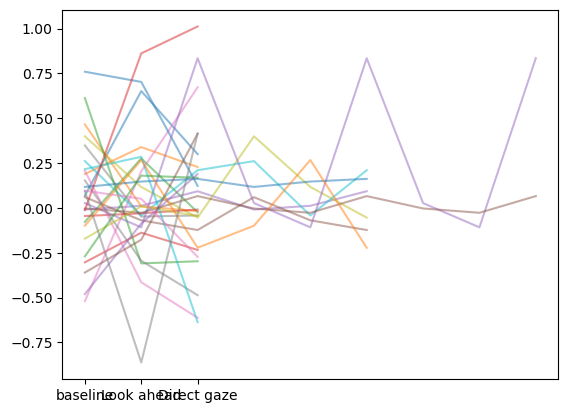

In [10]:
for a in arousals_hot: 
    plt.plot(a, alpha = 0.5)
    
plt.xticks(np.arange(3), conditions)
plt.show()

## HR exploratory analysis

In [11]:
hr_pds = [] 
count = 0

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    
    if not os.path.isfile(f): 
        count += 1
        
        hr_pd  = pd.read_csv(f + '/hr_recordings.csv')
        hr_pds.append(hr_pd)
        
print(f"There a {count} recordings")
        
hr_res = pd.concat(hr_pds,axis=0, ignore_index=True)

# add unique identifier
uniqueId = hr_res.trialId + hr_res.deviceId
hr_res.insert (0, "uniqueId", uniqueId)

There a 14 recordings


### HR Stationary signal analysis

A central premise of this experiment was that hot environment creates a signal with different characteristics (stationary vs non-stationary) that would affect prediction. Classifiers have used time measures that assume a stationary signal [ref], and so it is important to ensure this difference in recordings. 

In [12]:
hr_hot = []
hr_room = []

for rec in hr_res.uniqueId.unique():
    signal = hr_res[(hr_res.uniqueId == rec) & (hr_res.currentEnv == 'Hot')].hrString.values
    signal = signal - (signal[0:5].sum() / 5)
    hr_hot.append(signal) 
    
for rec in hr_res.uniqueId.unique():
    signal = hr_res[(hr_res.uniqueId == rec) & (hr_res.currentEnv == 'Room')].hrString.values
    signal = signal - (signal[0:5].sum() / 5)
    hr_room.append(signal) 

In [13]:
def plot_hr(hr_list, env_string): 
    
    # get recordings of same length
    l =  min([len(i) for i in hr_list])
    hr_list = [i[:l] for i in hr_list]
    
    fig, ax = plt.subplots(figsize=(8, 4))

    for val in hr_list: 
        plt.plot(val, alpha = 0.3)

    plt.title("Hr changes over time in hot environment")
    plt.xlabel("seconds")
    plt.ylabel("change in hr")
    
    # calculate average and plot line of best fit

    norm_hot = []
    for val in hr_list: 
        val = val - (val[:10].sum() / 10)
        norm_hot.append(val)

    ave = [] 
    for ind in range(l):
        ave.append(np.mean([d[ind] for d in norm_hot]))

    x = np.arange(len(ave))
    y = ave
    
    coeff = np.polyfit(x, y, 1)
    
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black')
    plt.title(f'Hr over time in {env_string} environment')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    ax.annotate(f'gradient: {coeff[0]:.2f}', xy=(10, 10), xycoords='figure pixels')
    plt.savefig(fig_local + f'hr_over_time_{env_string}_env.png')                    
    plt.show()
    
    return 

#### Measure: 

Below are graphs showing the change in HR signals over time. The average of the initial 10 readings was used as a baseline and subtracted from the signal. A line of best fit was fitted to the average of the recordings by minimised squared error. The room temperature environment largely shows a stationary signal. The gradient is shown in the bottom left

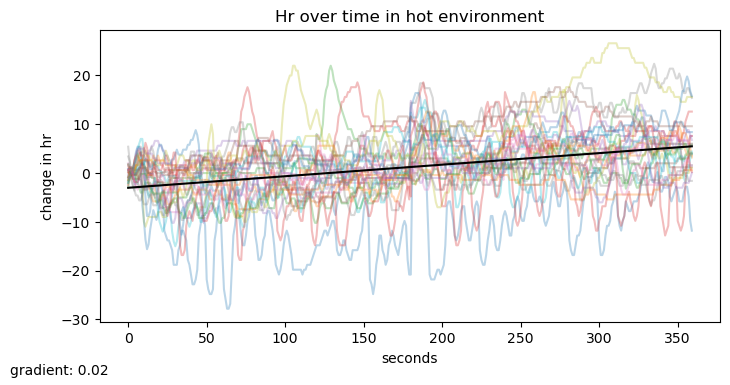

In [14]:
plot_hr(hr_hot, "hot")

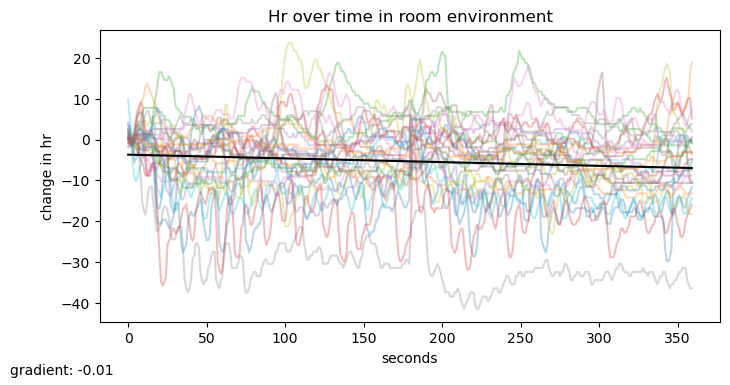

In [15]:
plot_hr(hr_room, "room")

##### Interpretation: 
The slight downward slope could be explained by the majority of conditions thus far starting in the “hot” condition, with a return to resting heart rate when switching to room temperature. The consistent upward slope in the hot environment demonstrates a non-stationary signal as expected. 

#### Measure: 
Considering each signal independently and fitting a line with least squares, the gradients are show below

In [16]:
def get_coeffs(hr_list):
    coeffs = []
    for rec in hr_list: 
        x = np.arange(len(rec))
        y = rec
        coeff = np.polyfit(x, y, 1)
        coeffs.append(coeff[0])
    return coeffs 

hot_coeffs = get_coeffs(hr_hot)
room_coeffs = get_coeffs(hr_room)

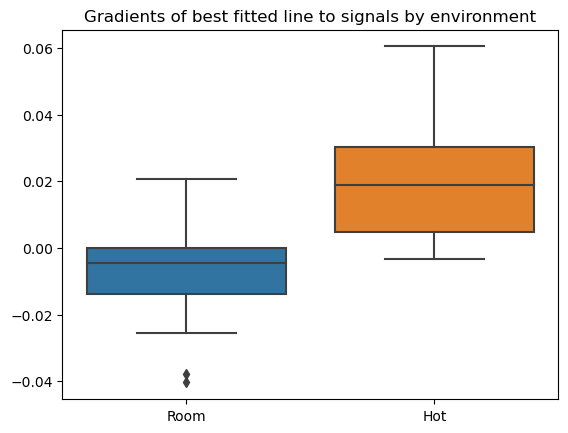

In [17]:
ax = sns.boxplot(data=[room_coeffs, hot_coeffs])
ax.set_xticklabels(["Room","Hot"])
title = 'Gradients of best fitted line to signals by environment'
plt.title(title)
plt.savefig(fig_local + title + '.png')
plt.show()

Test with Wilcoxon Signed-Rank Test: paired samples, no assumptions about normal distribution

In [18]:
# Example of the Wilcoxon Signed-Rank Test
from scipy.stats import wilcoxon

stat, p = wilcoxon(hot_coeffs, room_coeffs)

print(f'The Wilcoxon Signed-Rank Test p value is {p:.3f}')

if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

The Wilcoxon Signed-Rank Test p value is 0.000
Probably different distributions


# Feature extraction 

## ECG feature extraction




### Single measures 

##### From initial project proposal

"ECG measurements will be down-sampled to 256 with a high pass filter at 0.5Hz. R-peaks detected with Pan and Tompkins, resulting in semi-time series IBI, transformed into time-series by interpolating consecutive intervals as detailed in [24]. Heart-rate variability (HRV) features will be computed on IBI (SDNN, RMSSD, PNN50, peakLF, peakHF, powerVLF, powerLF, powerHF, relative powerVLF, relative powerLF, relative powerHF, LF/HF, sample entropy). [7] "

In [19]:
# function to extract ecg features
def get_ecg_features(signal, freq_method = 'lomb'): 
    t, signal, rpeaks = biosppy.signals.ecg.ecg(signal=signal, sampling_rate=130, show=False)[:3]
    
    # extract nni
    nni = tools.nn_intervals(t[rpeaks])
    
    # extract results 
    res = pyhrv.hrv(nni=nni, show=False)
    
    # time domain features 
    time_features =  ['nni_mean', 'nni_diff_mean', 'hr_mean', 'hr_min', 'hr_max', 'hr_std', 'sdnn', 'rmssd', 'pnn50', 'pnn20']
    
    time_features_results = []
    for f in time_features: 
        time_features_results.append(res[f])
    
    # frequency domain features
    peakVLF, peakLF, peakHF = res[freq_method + '_peak']
    powerVLF, powerLF, powerHF = res[freq_method + '_abs']
    relVLF, relLF, relHF = res[freq_method + '_rel']
    ratio = res[freq_method + '_ratio']
    
    freq_features_results = [peakVLF, peakLF, peakHF, powerVLF, powerLF, powerHF, relVLF, relLF, relHF, ratio]
    
    
    # non-linear measures 
    non_linear_features = ['sd1','sd2','sd_ratio','ellipse_area', 'sampen','dfa_alpha1','dfa_alpha2']
    
    non_linear_features_results = []
    for f in non_linear_features: 
        non_linear_features_results.append(res[f])
        
    
    return time_features_results + freq_features_results + non_linear_features_results

# define ecg feature headings 
ECG_FEATURE_NAMES = ['nni_mean', 'nni_diff_mean', 'hr_mean', 'hr_min', 'hr_max', 'hr_std', 'sdnn', 'rmssd', 'pnn50', 'pnn20'] + ['peakVLF', 'peakLF', 'peakHF', 'powerVLF', 'powerLF', 'powerHF', 'relVLF', 'relLF', 'relHF', 'ratio'] + ['sd1','sd2','sd_ratio','ellipse_area', 'sampen','dfa_alpha1','dfa_alpha2']
    

In [20]:
ecg_pds = [] 

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    
    if not os.path.isfile(f): 
        
        ecg_pd  = pd.read_csv(f + '/ecg_recordings.csv')
        ecg_pds.append(ecg_pd)

In [21]:
res = pd.concat(ecg_pds,axis=0, ignore_index=True)

In [22]:
# group baseline readings with exp condition 
r = res.copy()
r['baseline'] = r.currentCon == 'Eyes closed'
r['currentCon'].replace('Eyes closed', np.NaN, inplace=True)
r.fillna(method="bfill", inplace=True)

In [23]:
# limit to current experimental conditions
ri = r[r.currentCon.isin(['Direct gaze', 'Look ahead'])]

In [24]:
# want to create df with trialId, deviceId, Id, currentCon, Current,enV baseline readings, experiment readings, 
def group_base(res): 
    l = []
    for trialId in res.trialId.unique():
        for deviceId in res.deviceId.unique():
            r = res[(res.trialId == trialId) & (res.deviceId == deviceId)].copy()
            
            for env in r.currentEnv.unique(): 
                for con in r.currentCon.unique(): 
                    base_readings = r[(r.currentCon == con) & (r.currentEnv == env) & (r.baseline == True)].uvString.values
                    exp_readings = r[(r.currentCon == con) & (r.currentEnv == env) & (r.baseline == False)].uvString.values
                    l.append([trialId, deviceId, con, env, base_readings, exp_readings])
    
    cols = ['trialId', 'deviceId', 'currentCon', 'currentEnv', 'base_uv', 'exp_uv']
    
    res_df = pd.DataFrame(l, columns = cols)
    
    return res_df
            
            
            

In [25]:
# create df, with base readings, and exp readings in each row
group_df = group_base(ri)

In [26]:
%%capture capt

group_df['base_features'] = group_df.base_uv.apply(get_ecg_features)
group_df['exp_features'] = group_df.exp_uv.apply(get_ecg_features) 


In [27]:
def norm_features(row): 
    def convert(rec): 
        return np.nan_to_num(np.array(rec,dtype ='float64'))
    return convert(row.exp_features)  - convert(row.base_features)

In [28]:
group_df['norm_exp_features'] = group_df.apply(norm_features, axis=1)

In [29]:
group_df.sample()

,trialId,deviceId,currentCon,currentEnv,base_uv,exp_uv,base_features,exp_features,norm_exp_features
49,8901PK,A9332827,Direct gaze,Room,"[-81, -93, -76, -64, -59, -55, -50, -43, -35, ...","[-33, -45, -43, -21, -7, -2, 23, 57, 55, 47, 6...","[733.6363636363636, 25.633333333333333, 82.184...","[722.089430894309, 23.040983606557376, 83.7784...","[-11.54693274205465, -2.592349726775957, 1.594..."


In [30]:
group_df['target'] = group_df.currentCon.map({'Direct gaze':1, 'Look ahead':0})

In [31]:
def col_to_features(df, col_name, columns=ECG_FEATURE_NAMES): 
    return pd.DataFrame(df[col_name].to_list(), columns=columns)

#### Correlation measures

In [32]:
def find_paired_sample(row): 
    return group_df[
        (group_df.trialId == row.trialId)
        & (group_df.currentCon == row.currentCon)
        & (group_df.currentEnv == row.currentEnv) 
        & (group_df.deviceId != row.deviceId)].exp_uv.values[0]

In [33]:
group_df['paired_exp_uv'] = group_df.apply(find_paired_sample, axis=1)

In [34]:
group_df.sample()

,trialId,deviceId,currentCon,currentEnv,base_uv,exp_uv,base_features,exp_features,norm_exp_features,target,paired_exp_uv
29,1433PP,A9332B2A,Look ahead,Hot,"[-79, -69, -69, -65, -57, -50, -45, -45, -43, ...","[185, 214, 241, 258, 277, 291, 291, 284, 277, ...","[830.9439252336449, 13.547169811320755, 72.270...","[814.1100917431193, 12.824074074074074, 73.750...","[-16.83383349052565, -0.7230957372466804, 1.47...",0,"[-55, -50, -4, 198, 517, 577, 201, -148, -124,..."


In [35]:
pair = group_df[(group_df.trialId == '6133PP') & (group_df.currentCon == 'Direct gaze') & (group_df.currentEnv == 'Hot')]

In [48]:
SYNC_FEATURES = ['pearson_r', 'pearson_p', 'time_lagged_max_corr', 'time_lagged_lag']

def get_synchrony_measures(row): 
    signalA = row.exp_uv
    signalB = row.paired_exp_uv
    
    min_len = min(len(signalA), len(signalB))

    ecg_signal1 = signalA[:min_len]
    ecg_signal2 = signalB[:min_len]
    
    r, p = stats.pearsonr(ecg_signal1,ecg_signal2)
    
    correlation = scipy.signal.correlate(ecg_signal1, ecg_signal2, mode="full")
    max_corr = correlation.max() 
    lags = scipy.signal.correlation_lags(ecg_signal1.size, ecg_signal2.size, mode="full")
    lag = lags[np.argmax(correlation)]
    
    sync_results = [r, p, max_corr, lag]
    
    return sync_results

In [49]:
group_df['sync_exp_features'] = group_df.apply(get_synchrony_measures, axis=1)

### Feature analysis

In [50]:
# define function to get correlation table based on features and environments

def corr_col(df, col_name, envs, columns, graph=False):
    
    df = df[df.currentEnv.isin(envs)]
    
    features = col_to_features(df, col_name, columns=columns)
    
    corr = features.corrwith(df.target.astype('float'), method=scipy.stats.pointbiserialr).iloc[1]
    
    if graph:
        sns.barplot(corr.index, corr.values)
        plt.xticks(rotation=75)
        plt.title(f'Point biserial coeff with direct gaze in {envs}')
        plt.show()
    
    return corr

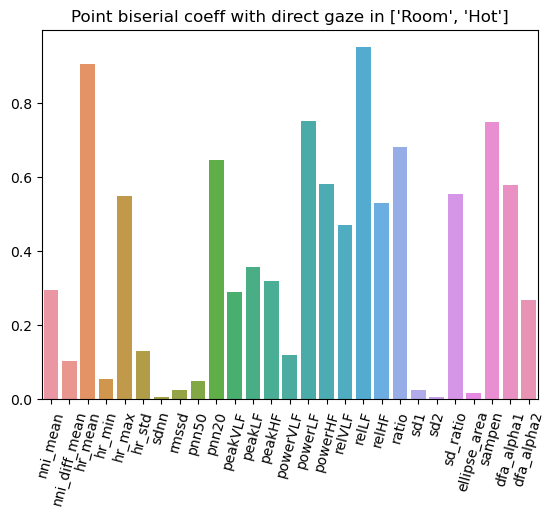

In [51]:
_ = corr_col(group_df, 'norm_exp_features', ['Room','Hot'], ECG_FEATURE_NAMES, graph=True)

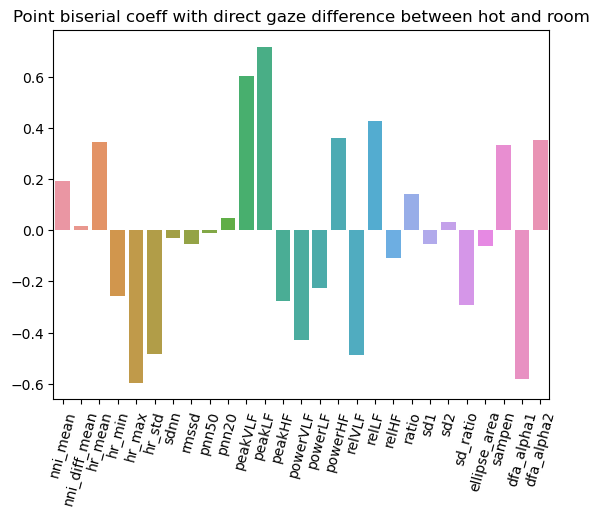

In [52]:
# plot difference in features 
hot_corr = corr_col(group_df, 'norm_exp_features',['Hot'], ECG_FEATURE_NAMES)
room_corr = corr_col(group_df, 'norm_exp_features', ['Room'], ECG_FEATURE_NAMES)

diff_corr = hot_corr - room_corr

sns.barplot(diff_corr.index, diff_corr.values)
plt.xticks(rotation=75)
plt.title('Point biserial coeff with direct gaze difference between hot and room')
plt.show()

#### Synchrony measures analysis

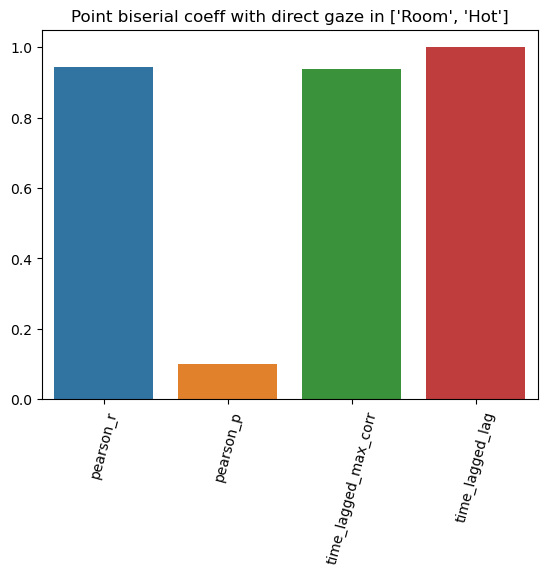

In [54]:
_ = corr_col(group_df, 'sync_exp_features', ['Room','Hot'], SYNC_FEATURES, graph=True)

## Classification

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [56]:
def run_model(model, X, y):
    
    #cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
    
    X = X.replace('nan',0)
    
    ct = ColumnTransformer([
        ('scale', StandardScaler(),
         make_column_selector(dtype_include=np.number))])


    pipe = Pipeline(steps=[
        ('scaler', ct),
        ('clf', model)])
    
    predictions = cross_val_predict(pipe, X, y, cv=10)
    
    # Calculate metrics
    accuracy = accuracy_score(predictions, y)
    precision = precision_score(predictions, y)
    recall = recall_score(predictions, y)
    f1 = f1_score(predictions, y)
    
    # cross_val_score(pipe, X, y, cv=10).mean()

    return {'accuracy':accuracy, 'precision':precision, 'recall':recall, 'f1':f1}

In [57]:
# define models 
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import SVC
models['Support Vector Machines'] = SVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

# XGBoost
from xgboost import XGBClassifier
models['XGB'] = XGBClassifier()

In [58]:
def run_all_models(models, X, y): 
    
    scores = []
    
    for model_name, model in models.items():
        score = run_model(model, X, y) 
        
        scores.append([model_name, score['accuracy'], score['precision'], score['recall'], score['f1']]) 
    
    return pd.DataFrame(scores, columns=['model','acc','precision','recall','f1'])
        

### Fit Classifier

#### In distribution testing

In [59]:
def run_exp(feature_name, envs, models, feature_names): 
    d = group_df[group_df.currentEnv.isin(envs)]
    X = col_to_features(d, feature_name, feature_names)
    y = d.target
    
    return run_all_models(models, X, y)

In [62]:
pos_envs = [['Room'],['Hot'],['Room','Hot']]
features_variations = [(ECG_FEATURE_NAMES, 'exp_features'),
                  (ECG_FEATURE_NAMES, 'norm_exp_features'),
                  (SYNC_FEATURES,'sync_exp_features')]

In [63]:
exp_results = []

for e in pos_envs:
    for f in features_variations:
        
        feature = f[1]
        feature_names = f[0]

        scores_df = run_exp(feature, e, models, feature_names)
        
        scores_df.insert(0, 'feature_name', feature)
        
        env_string = ''
        for en in e: 
            env_string += en + ' '
        
        env_string = 'Train: ' + env_string + 'to Test: ' + env_string
        
        scores_df.insert(0, 'env', env_string)
        
        
        exp_results.append(scores_df)

In [64]:
res_df = pd.concat(exp_results, axis=0)

In [65]:
res_df.head()

,env,feature_name,model,acc,precision,recall,f1
0,Train: Room to Test: Room,exp_features,Logistic Regression,0.392857,0.392857,0.392857,0.392857
1,Train: Room to Test: Room,exp_features,Support Vector Machines,0.410714,0.285714,0.380952,0.326531
2,Train: Room to Test: Room,exp_features,Decision Trees,0.500000,0.428571,0.500000,0.461538
3,Train: Room to Test: Room,exp_features,Random Forest,0.428571,0.357143,0.416667,0.384615
4,Train: Room to Test: Room,exp_features,Naive Bayes,0.428571,0.642857,0.450000,0.529412


In [66]:
# plot XGB f1 across different features and envs 

In [67]:
xgb_res = res_df[res_df.model == 'XGB'][['env', 'feature_name', 'f1']]
xgb_res

,env,feature_name,f1
6,Train: Room to Test: Room,exp_features,0.474576
6,Train: Room to Test: Room,norm_exp_features,0.603774
6,Train: Room to Test: Room,sync_exp_features,0.545455
6,Train: Hot to Test: Hot,exp_features,0.464286
6,Train: Hot to Test: Hot,norm_exp_features,0.700000
6,Train: Hot to Test: Hot,sync_exp_features,0.774194
6,Train: Room Hot to Test: Room Hot,exp_features,0.450450
6,Train: Room Hot to Test: Room Hot,norm_exp_features,0.605505
6,Train: Room Hot to Test: Room Hot,sync_exp_features,0.612613


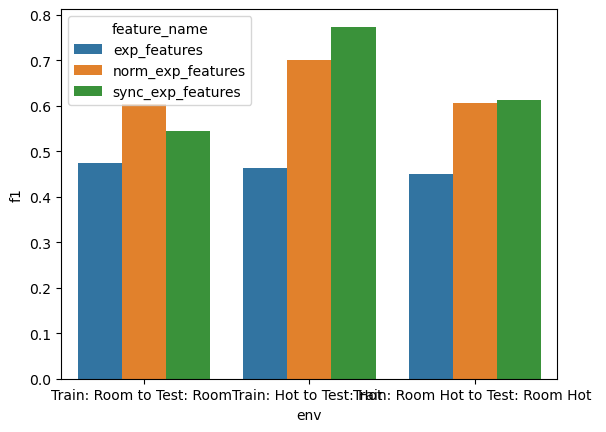

In [68]:
sns.barplot(data=xgb_res, x='env', y='f1', hue='feature_name')
plt.show()

#### Out of distribution testing

In [69]:
train_test_envs = [['Room','Hot'],['Hot','Room']]
features_names = ['exp_features','norm_exp_features']     

In [70]:
out_dist_test_results = []
out_dist_test_results_headings = ['train_env','test_env', 'feature_name', 'f1']

for c in train_test_envs:
    for f in features_variations:
        train_env = c[0]
        test_env = c[1]
        
        feature_names = f[0]
        feature = f[1]
        
        train_df = group_df[group_df.currentEnv == train_env]
        test_df = group_df[group_df.currentEnv == test_env]
        
        X_train = col_to_features(train_df, feature, feature_names).replace('nan', 0)
        X_test = col_to_features(test_df, feature, feature_names).replace('nan', 0)
        
        y_train = train_df.target
        y_test = train_df.target
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        clf = XGBClassifier()
        clf.fit(X_train, y_train) 
        y_pred = clf.predict(X_test) 
        score = f1_score(y_pred, y_test)
        
        out_dist_test_results.append([train_env, test_env, feature, score])

out_dist_test_results_df = pd.DataFrame(out_dist_test_results, columns=out_dist_test_results_headings)

In [71]:
out_dist_test_results_df

,train_env,test_env,feature_name,f1
0,Room,Hot,exp_features,0.586207
1,Room,Hot,norm_exp_features,0.666667
2,Room,Hot,sync_exp_features,0.347826
3,Hot,Room,exp_features,0.500000
4,Hot,Room,norm_exp_features,0.645161
5,Hot,Room,sync_exp_features,0.437500


In [72]:
out_dist_test_results_df['env'] = 'Train: ' + out_dist_test_results_df.train_env + ' to Test: ' + out_dist_test_results_df.test_env 

In [73]:
out_dist_xbg_res = out_dist_test_results_df[['env','feature_name','f1']]

In [74]:
all_xgb_res = pd.concat([xgb_res, out_dist_xbg_res],axis=0)

In [75]:
all_xgb_res

,env,feature_name,f1
6,Train: Room to Test: Room,exp_features,0.474576
6,Train: Room to Test: Room,norm_exp_features,0.603774
6,Train: Room to Test: Room,sync_exp_features,0.545455
6,Train: Hot to Test: Hot,exp_features,0.464286
6,Train: Hot to Test: Hot,norm_exp_features,0.700000
6,Train: Hot to Test: Hot,sync_exp_features,0.774194
6,Train: Room Hot to Test: Room Hot,exp_features,0.450450
6,Train: Room Hot to Test: Room Hot,norm_exp_features,0.605505
6,Train: Room Hot to Test: Room Hot,sync_exp_features,0.612613
0,Train: Room to Test: Hot,exp_features,0.586207


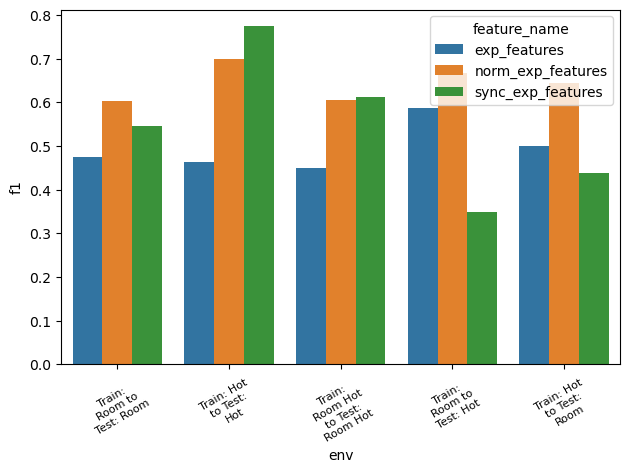

In [76]:
import textwrap
sns.barplot(data=all_xgb_res, x='env', y='f1', hue='feature_name')

labels = all_xgb_res.env.unique()
x_axis=range(len(labels))

# Note list comprehension in the next line
plt.xticks(x_axis, [textwrap.fill(label, 10) for label in labels], 
           rotation = 30, fontsize=8, horizontalalignment="center")
plt.tight_layout()           # makes space on the figure canvas for the labels
plt.tick_params(axis='x', pad=6) 


plt.show()

In [78]:
print("test")

test


In [80]:
!git add .

In [82]:
!git commit

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   analysis.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [84]:
!git remote

origin


In [90]:
!git config --global user.name "microchimp"

In [ ]:
!git push -u origin

Username for 'https://github.com': 